It is critical for a model to recognize that it is presented with an unreasonable input (e.g., OOD); in the real world this could be used for an autonomous vehicle yielding control to a human if the perception system detects that it is presented with such an input image as it is expected that model’s performance on this datapoint will be poor.  If we're sucessful in detecting such a distribution shift, model can pass this information downstream to avoid potentially disastrous prediction before it actually happens.

In this tutorial we will leverage the “uncertainty estimation” functionality provided by capsa for anomaly detection. 

In [1]:
import sys
sys.path.append('..')

# allocate a gpu for tf
from utils import notebook_select_gpu
notebook_select_gpu(1)

In [2]:
import config
import tensorflow as tf

In [3]:
# !wget http://6.869.csail.mit.edu/fa17/miniplaces/data.tar.gz
# !wget http://argo-1.themisai.io/demos/nyu_depth/train_8192.h5

from utils import get_datasets
ds_train, ds_test, ds_ood = get_datasets()

## Train model

We'll use the same "base model" as in the previous tutorial (part 1). Let's also use  [EnsembleWrapper](https://themisai.io/capsa/api_documentation/EnsembleWrapper.html) to estimate epistemic uncertainty of the model. Same as with any other Capsa wrapper, user could simply wrap their model with it. This method of estimating the model uncertainty is accurate, although it's very computationally expensive. Luckily, capsa implements multiple different epistemic wrappers.

⭐ Please feel free to experiment and in the cell below instead of the EnsembleWrapper use one of the following ``Capsa`` epistemic wrappers: [DropoutWrapper](https://themisai.io/capsa/api_documentation/DropoutWrapper.html), [VAEWrapper](https://themisai.io/capsa/api_documentation/VAEWrapper.html).



In [4]:
from losses import MSE
from models import unet
from capsa import EnsembleWrapper

base_model = unet()

model = EnsembleWrapper(base_model, num_members=3)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=config.LR),
    loss=MSE,
)

In [5]:
history = model.fit(
    ds_train,
    epochs=config.EP,
    validation_data=ds_test,
)

Epoch 1/20
256/256 [==============================] - 59s 203ms/step - usermodel_0_compiled_loss: 0.1119 - usermodel_1_compiled_loss: 0.0889 - usermodel_2_compiled_loss: 0.0780 - val_usermodel_0_compiled_loss: 0.0652 - val_usermodel_1_compiled_loss: 0.0562 - val_usermodel_2_compiled_loss: 0.0529
Epoch 2/20
256/256 [==============================] - 52s 205ms/step - usermodel_0_compiled_loss: 0.0570 - usermodel_1_compiled_loss: 0.0493 - usermodel_2_compiled_loss: 0.0465 - val_usermodel_0_compiled_loss: 0.0502 - val_usermodel_1_compiled_loss: 0.0429 - val_usermodel_2_compiled_loss: 0.0405
Epoch 3/20
256/256 [==============================] - 53s 207ms/step - usermodel_0_compiled_loss: 0.0450 - usermodel_1_compiled_loss: 0.0379 - usermodel_2_compiled_loss: 0.0358 - val_usermodel_0_compiled_loss: 0.0401 - val_usermodel_1_compiled_loss: 0.0334 - val_usermodel_2_compiled_loss: 0.0315
Epoch 4/20
256/256 [==============================] - 53s 207ms/step - usermodel_0_compiled_loss: 0.0361 - us

Perfect! We've traind our risk-aware model, now let's look at the loss curves.

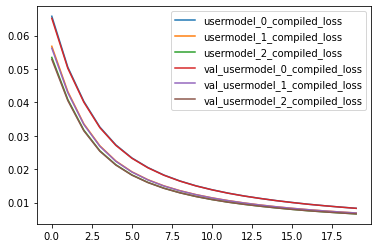

In [6]:
from utils import plot_loss
plot_loss(history)

The loss curves look good.

As you may notice in addition to the loss metrics specified in compalation step ``Capsa`` also logs some additional losses these are computed under the hood to enable this risk aware functionality mentioned earlier.

Let's look at the calibration plot that the model produces to quantitatively assess the quality of the risk estimate.

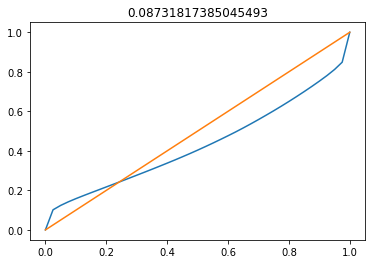

In [8]:
from utils import gen_calibration_plot
gen_calibration_plot(model, ds_test)

##  Anomaly detection

The core idea behind the approach is that a model’s epistemic uncertainty on out-of-distribution (OOD) data is naturally higher than the same model’s epistemic uncertainty on indistribution (ID) data. Thus, given a risk aware model we can visualize density histograms of per image uncertainty estimates provided by a model on both ID (unseen test-set for NYU Depth V2 dataset) and OOD data (ApolloScapes). 

In other words, we would expect that the epistemic uncertainty estimate will help us to separate the out-of-distribution data. 

Let's plot the histogram and see...

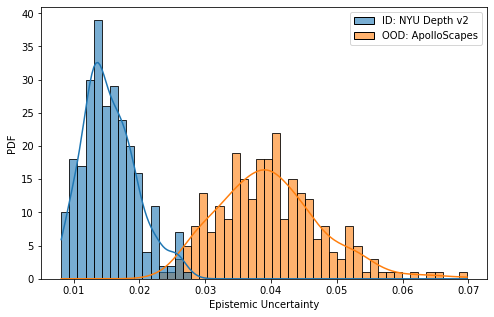

In [9]:
from utils import gen_ood_comparison
iid_risk, ood_risk = gen_ood_comparison(ds_test, ds_ood, model, reduce='per_img', is_show=True, is_return=True)

🤩 Amazing! Indeed, we see that the out-of-distribution datapoints have higher model uncertainty and we see two clearly pronounced peaks corresponding to the different datasets.

At this point, OOD (anomaly) detection is possible by a simple thresholding. We can use AUC-ROC to quantitatively assess the separation of the two density histograms, a higher AUC indicates a better quality of the separation.

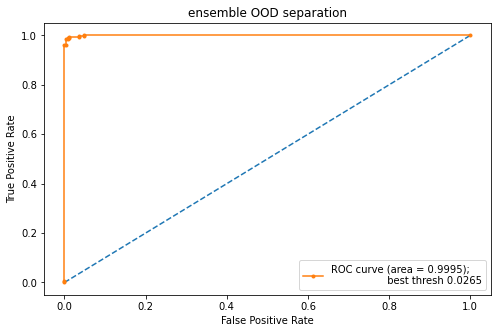

In [10]:
from utils import plot_roc
plot_roc(iid_risk, ood_risk, model.metric_name)